In [21]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Imports d'utilitats pròpies
from utils.dataset import IDC_Dataset, load_dataset, create_transforms
from utils.models import ConvNet


In [22]:
# Desactivem un warning de pytorch que podem ignorar (https://github.com/pytorch/pytorch/issues/97207) 
import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                        message='TypedStorage is deprecated')


In [23]:
# Carreguem el dataset a partir del path on es troben les imatges
base_path = "./dataset/IDC_regular_ps50_idx5"
images, labels, metadata = load_dataset(base_path)

# Calcular mitjana i desviació estàndard per a normalitzar les imatges
mean = np.mean(images, axis=(0, 1, 2)) / 255
std = np.std(images, axis=(0, 1, 2)) / 255

data_transforms = create_transforms(mean, std)

Carregant imatges IDC-positives...: 100%|██████████| 78224/78224 [00:13<00:00, 5608.05it/s]


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 10
batch_size = 32
learning_rate = 0.0001
positive_threshold = 0.5

# Calculem el pes de les classes per a reduir l'esbiaixament del model
num_positives = np.sum(labels)
num_negatives = len(labels) - num_positives
pos_weight = num_negatives / num_positives
pos_weight = torch.tensor(pos_weight).to(device)

# Instanciem el dataset i el dataloader
dataset = IDC_Dataset(images, labels, metadata, transform=data_transforms)
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instanciem el model per a cada fold
model = ConvNet().to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Guardem la matriu de confusió per a cada època de l'entrenament del model
confusion_matrices = []

for epoch in range(epochs):
    # Entrenament del model
    model.train()

    # Inicialitzem la matriu de confusió per a cada època
    epoch_cm = np.zeros((2, 2))
    for train_inputs, train_labels, _ in tqdm(dataset_loader, desc=f"TRAINING EPOCH {epoch+1}/{epochs}", unit=" batches"):
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        optimizer.zero_grad()
        outputs = model(train_inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        outputs = torch.sigmoid(outputs)
        predictions = (outputs > positive_threshold).float()

        epoch_cm += confusion_matrix(train_labels.cpu().numpy(), predictions.cpu().numpy())

    # Guardem la matriu de confusió per a cada època
    confusion_matrices.append(epoch_cm)


TRAINING EPOCH 10/10: 100%|██████████| 8515/8515 [01:15<00:00, 112.99 batches/s]


In [25]:
# Guardem el model entrenat
torch.save(model.state_dict(), 'model_entrenat.pt')

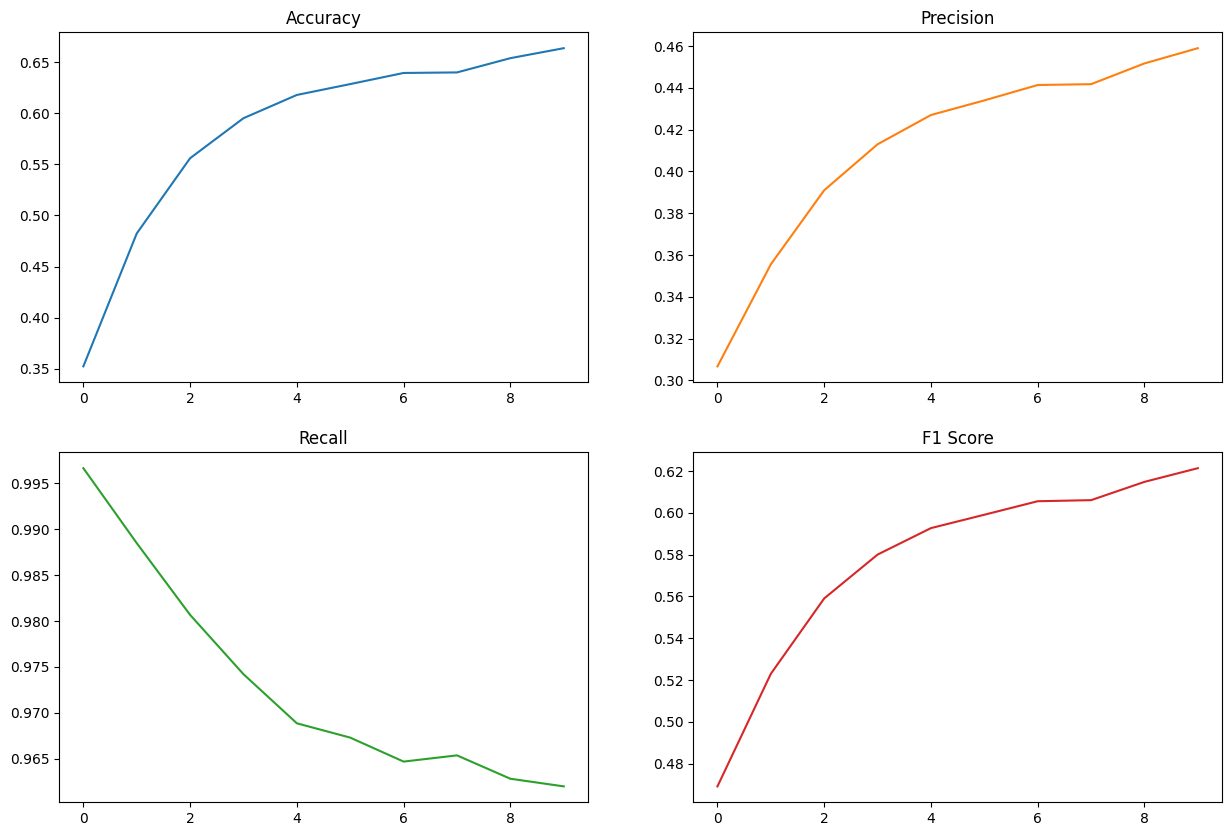

In [26]:
def compute_metrics(confusion_matrices):
    # Mètriques que calcularem
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch_cm in confusion_matrices:
        # Calcular les mètriques per a cada epoch
        tn, fp, fn, tp = epoch_cm.ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision +
                                         recall) if (precision + recall) > 0 else 0

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    accuracies = np.array(accuracies)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = np.array(f1_scores)

    return accuracies, precisions, recalls, f1_scores


def plot_metrics(accuracies, precisions, recalls, f1_scores):
    _, axs = plt.subplots(2, 2, figsize=(
        15, 10), squeeze=False, sharex=False, sharey=False)

    axs[0, 0].plot(accuracies)
    axs[0, 0].set_title('Accuracy')

    axs[0, 1].plot(precisions, 'tab:orange')
    axs[0, 1].set_title('Precision')

    axs[1, 0].plot(recalls, 'tab:green')
    axs[1, 0].set_title('Recall')

    axs[1, 1].plot(f1_scores, 'tab:red')
    axs[1, 1].set_title('F1 Score')

    plt.show()


metrics = compute_metrics(confusion_matrices)
plot_metrics(*metrics)
